# SISTEMA DE TRANSAÇÃO EM PYTHON

## Objetivo Geral

Implementar um sistema de conta bancária em Python, integrado com um banco de dados no PostgreSQL, capaz de realizar as seguintes operaçõe: sacar, depositar, consultar informações da conta bancária, consultar informações de saldo e visualizar o extrato bancário.

## Análise de Requisitos

O sistema implementado deve atender os seguintes requisitos:



**Operação de Depósito**

* O usuário só pode depositar valores positivos na conta;

**Operação de Saque**

* O sistema deve permitir realizar 3 saques diários com limite máximo de R$ 500,00 por saque;
* Se o usuário não tem saldo na conta, o sistema deve exibir uma mensagem informando que não é possível sacar por saldo insuficiente.

**Operação de Extrato**

* Listar todos os depósitos e saques realizados na conta em uma data especificada pelo usuário;
* No fim do extrato deve ser exibido o saldo atual da conta;
* Se o extrato estiver em branco. exibir a mensagem: "Não foram realizadas movimentações"

## Modelagem do Banco de Dados

O banco de dados será criado para armazenar as informações do usuário, como conta, agência, senha, saldo, etc. A modelagem de banco de dados envolve duas etapas: modelagem conceitual e modelagem lógica.

* **Modelagem Conceitual**

Na modelagem conceitual, criamos um esquema visual em alto nível que ajuda a entender a estrutura geral do banco de dados. Este modelo apresenta as entidades, atributos e relacionamentos.

| Entidade | Atributo | Descrição |
|----------|----------|-----------|
|conta_bancaria| id_conta|Número da conta bancária|
|| agencia_id|Número da agência|
|| cliente_id|Referência ao id do cliente|
||saldo_disponivel|Saldo disponível para saques|
||tipo_conta|Tipo de conta (corrente, poupança, etc)|
||status_conta|Se a conta é ativa ou inativa|
||data_criacao|Data de criação da conta|
||data_fechamento|Data de fechamento da conta|
||senha_hash|Hash da senha do usuário|
|cliente|id_cliente|ID único do cliente|
||nome|Nome do cliente|
||data_nascimento|Data de nascimento do cliente|
||cpf|CPF do cliente|
||rg|RG do cliente|
||telefone|Número de telefone do cliente|
||email|Endereço de email do cliente|
|agencia|id_agencia|ID único da agência|
||nome|Nome da agência|
||rua|Rua da agência|
||cidade|Cidade da agência|
||estado|Estado da agência|
|transacao|id_transacao|Identificador único da transação|
||conta_id|Referência a conta do cliente|
||tipo|Tipo de transação: saque / depósito|
||data|Data da transação|
||valor|Valor da transação|
||saldo_final|Saldo após transação|
||saldo_inicial|Saldo antes da transação|

A Figura abaixo apresenta a modelagem conceitual construída a partir das informações contidas na tabela acima.

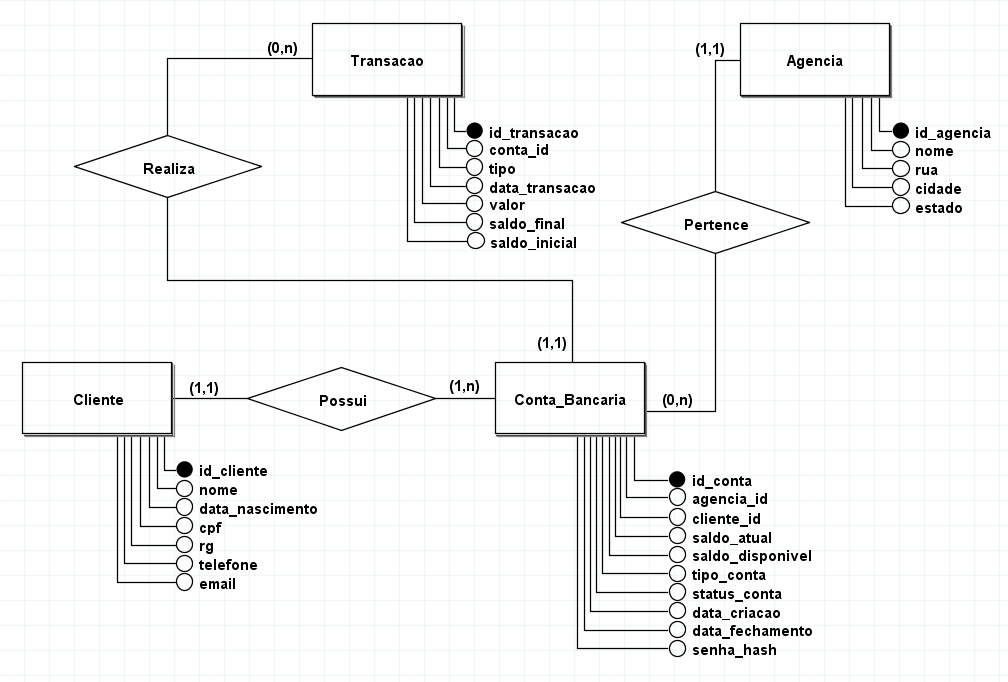

* **Modelagem Lógica**

No modelo lógico, definimos as estruturas de dados e os métodos para representar as informações no banco de dados. A Figura abaixo apresenta o modelo lógico construído utilizando como base o modelo conceitual contruído anteriormente.

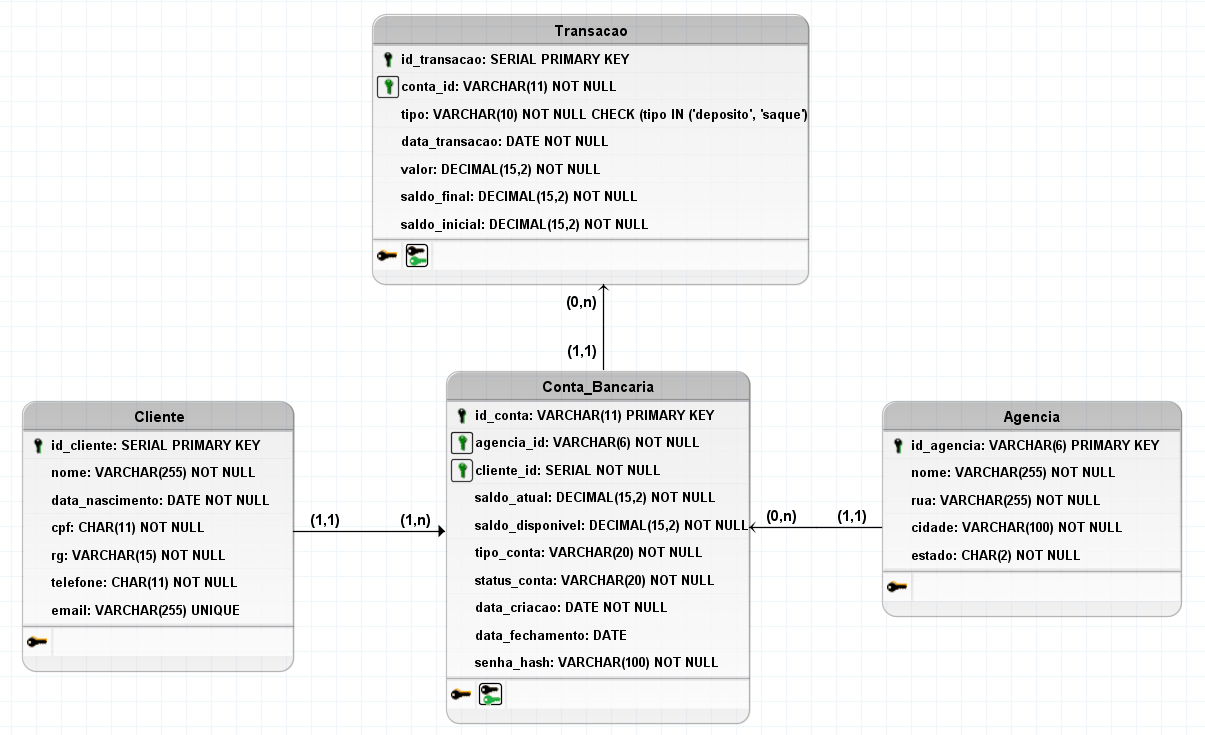

## Criação do Banco de Dados no PostgreSQL

A partir do modelo conceitual e modelo lógico, podemos implementar o banco de dados, respeitando as regras definidas durante a modelagem. Para implementação e manutenção do banco de dados, foi utilizado o sistema de gerenciamento de bancos de dados (SGBD) PostgreSQL.

* **Tabela "cliente"**

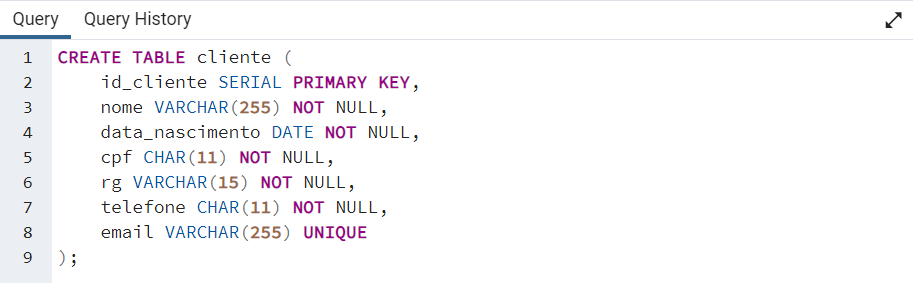

* **Tabela "agencia"**

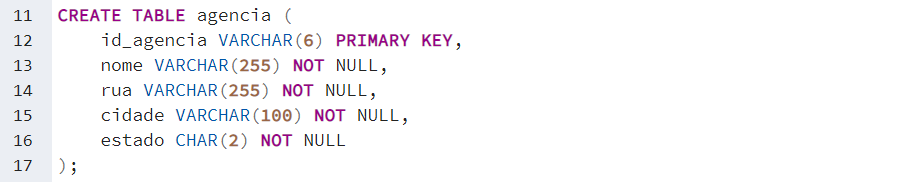

* **Tabela "conta_bancaria"**

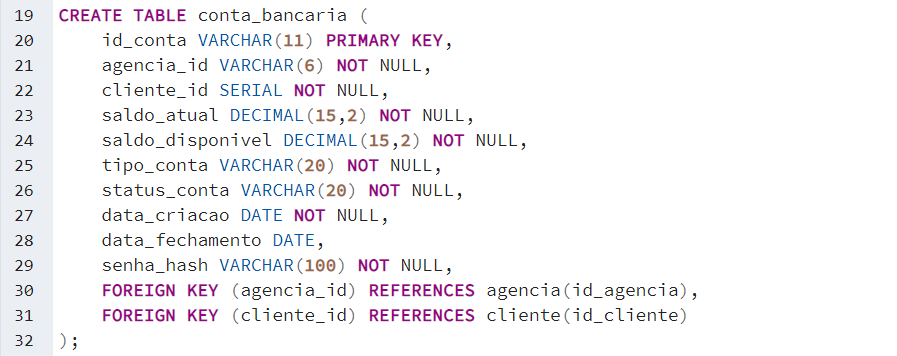

* **Tabela "transacao"**

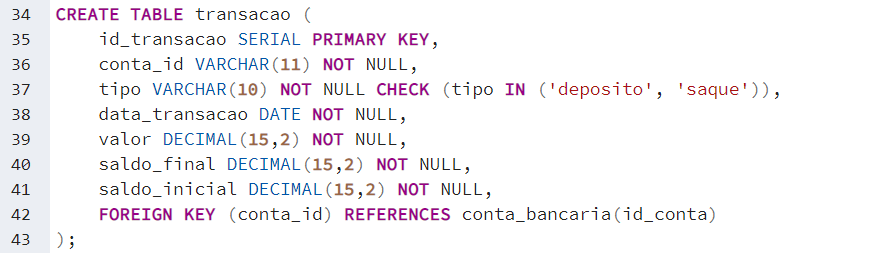

## Desenvolvimento do Algoritmo em Python

Criando a classe responsável pela manipulação da conta bancária

In [35]:
#Importação das bibliotecas
from datetime import datetime 
import psycopg2 
 
#Criando a classe "ContaBancaria"
class ContaBancaria:

    def __init__(self, id_conta, agencia_id):

        self.id_conta = id_conta
        self.agencia_id = agencia_id

        #Criando a conexão com o banco de dados

        self.conn = psycopg2.connect(
            host = 'localhost',
            database = 'sistema_bancario',
            user = 'postgres',
            password = 'pinkfloyd123'
        )

        #criando o cursor para execução de instruções em SQL
        self.cursor = self.conn.cursor()

    #Função responsável por realizar depósitos na conta bancária
    def depositar(self, valor):

        self.cursor.execute(
            "SELECT saldo_atual FROM conta_bancaria WHERE id_conta = %s",
            (self.id_conta,)
        )
        row = self.cursor.fetchone()
        saldo_inicial = row[0]
        saldo = row[0]


        if valor <= 0:
            print('O valor do depósito deve ser um número positivo.')
            return
        
        saldo += valor

        #Atualizar a conta bancária no banco de dados
        self.cursor.execute(
            "UPDATE conta_bancaria SET saldo_atual = %s WHERE id_conta = %s",
            (saldo, self.id_conta)
        )
        self.cursor.execute(
            "UPDATE conta_bancaria SET saldo_disponivel = %s WHERE id_conta = %s",
            (saldo, self.id_conta)
        )

        #Registrar a transação no banco de dados
        self.cursor.execute(
            """INSERT INTO transacao (conta_id, tipo, data_transacao, valor, saldo_final, saldo_inicial)
             VALUES (%s, %s, %s, %s, %s, %s)""",
            (self.id_conta, 'deposito', datetime.now().date(), valor, saldo, saldo_inicial)
        )

        self.conn.commit()
        print(f"Depósito de R$ {valor:.2f} realizado com sucesso. Seu saldo é R$ {saldo:.2f}")
    
    #Função responsável por realizar saques na conta bancária
    def sacar(self, valor):

        #consulta o número de saques feitos no dia
        self.cursor.execute(
            "SELECT COUNT(*) FROM transacao WHERE conta_id = %s AND tipo = 'saque' AND data_transacao::date = %s",
             (self.id_conta, datetime.now().date())
        )
        row = self.cursor.fetchone()
        saques_hoje = row[0]
        
        #Verificando o limite de saques diários
        if saques_hoje >= 3:
            print('Você já realizou três saques hoje. Não é possível realizar mais saques!')
            return

        self.cursor.execute(
            "SELECT saldo_atual FROM conta_bancaria WHERE id_conta = %s",
            (self.id_conta,)
        )
        row = self.cursor.fetchone()
        saldo_inicial = row[0]
        saldo = row[0]
    
        if valor <= 0:
            print('O valor do saque deve ser um número positivo')
            return
        if valor > 500:
            print('O valor do saque não pode exceder R$ 500,00.')
            return
        if saldo < valor:
            print('Saldo insuficiente para realizar o saque!')
            return
        
        saldo -= valor

        #Atualizar a conta bancária no banco de dados
        self.cursor.execute(
            "UPDATE conta_bancaria SET saldo_atual = %s WHERE id_conta = %s",
            (saldo, self.id_conta)
        )
        self.cursor.execute(
            "UPDATE conta_bancaria SET saldo_disponivel = %s WHERE id_conta = %s",
            (saldo, self.id_conta)
        )

        #Registrar a transação no banco de dados
        self.cursor.execute(
            """INSERT INTO transacao (conta_id, tipo, data_transacao, valor, saldo_final, saldo_inicial)
             VALUES (%s, %s, %s, %s, %s, %s)""",
            (self.id_conta, 'saque', datetime.now().date(), valor, saldo, saldo_inicial)
        )

        self.conn.commit()
        print(f"Saque de R$ {valor:.2f} realizado com sucesso. Seu saldo atual é R$ {saldo:.2f}")

    def consulta_conta(self):
        """
        Função responsável pela extração de informações da conta bancária, tais como: nome, número da conta,
        número da agência, tipo de conta e status da conta.
        """

        #consulta nome do cliente
        self.cursor.execute(
        """
        SELECT cliente.nome
        FROM cliente
        INNER JOIN conta_bancaria
        ON cliente.id_cliente = conta_bancaria.cliente_id
        WHERE conta_bancaria.id_conta = %s
        """,
        (self.id_conta,)
        )
        row = self.cursor.fetchone()
        nome_consulta = row[0]

        #consulta tipo de conta
        self.cursor.execute(
            "SELECT tipo_conta FROM conta_bancaria WHERE id_conta = %s",
            (self.id_conta,)
        )
        row = self.cursor.fetchone()
        tipo_conta_consulta = row[0]

        #consulta status da conta
        self.cursor.execute(
            "SELECT status_conta FROM conta_bancaria WHERE id_conta = %s",
            (self.id_conta,)
        )
        row = self.cursor.fetchone()
        status_conta_consulta = row[0]

        #consulta agência bancária
        self.cursor.execute(
            "SELECT agencia_id FROM conta_bancaria WHERE id_conta = %s",
            (self.id_conta,)
        )
        row = self.cursor.fetchone()
        agencia_consulta = row[0]

        #Exibindo as informações da conta bancária
        print('=============== INFORMAÇÕES CONTA BANCÁRIA ================\n')
        print(f"Nome do cliente: {nome_consulta}")
        print(f"Número da conta: {self.id_conta}")
        print(f"Número da agência: {agencia_consulta}")
        print(f"Tipo de conta: {tipo_conta_consulta}")
        print(f"Status da conta: {status_conta_consulta}\n")
        print(f"{datetime.now().date()}\n")
        print('===========================================================')


    def consulta_saldo(self):
        """
        Responsável pela extração de informações de saldo atual e disponível da conta.
        """

        #consulta Nome
        self.cursor.execute(
        """
        SELECT cliente.nome
        FROM cliente
        INNER JOIN conta_bancaria
        ON cliente.id_cliente = conta_bancaria.cliente_id
        WHERE conta_bancaria.id_conta = %s
        """,
        (self.id_conta,)
        )
        row = self.cursor.fetchone()
        nome_consulta = row[0]

        #conulta agência bancária
        self.cursor.execute(
            "SELECT agencia_id FROM conta_bancaria WHERE id_conta = %s",
            (self.id_conta,)
        )
        row = self.cursor.fetchone()
        agencia_consulta = row[0]

        #consulta saldo
        self.cursor.execute(
            "SELECT saldo_atual FROM conta_bancaria WHERE id_conta = %s",
            (self.id_conta,)
        )
        row = self.cursor.fetchone()
        saldo_consulta = row[0]

        #consulta saldo disponível
        self.cursor.execute(
            "SELECT saldo_disponivel FROM conta_bancaria WHERE id_conta = %s",
            (self.id_conta,)
        )
        row = self.cursor.fetchone()
        saldo_disponivel_consulta = row[0]

        #Exibindo as informações de saldo da conta bancária
        print('=============== SALDO DA CONTA BANCÁRIA ===================\n')
        print(f"Nome do cliente: {nome_consulta}")
        print(f"Número da conta: {self.id_conta}")
        print(f"Número da agência: {agencia_consulta}\n")
        print(f"Saldo atual: R$ {saldo_consulta}")
        print(f"Saldo disponível: R$ {saldo_disponivel_consulta}\n")
        print(f"{datetime.now().date()}\n")
        print('===========================================================')

    #Função responsável por exibir o extrato bancário
    def extrato(self, data_consulta):

        #Extrair as transações da conta no banco de dados

        """
        A função 'fetchall()' retorna todas as linhas da consulta SQL
        """

        self.cursor.execute(
            """SELECT tipo, data_transacao, valor, saldo_inicial, saldo_final FROM transacao WHERE conta_id = %s
             AND data_transacao = %s ORDER BY data_transacao""",
            (self.id_conta, data_consulta)
        )
        transacoes = self.cursor.fetchall()

        if not transacoes:
            print('Não foram realizadas movimentações bancárias na data informada.')
            return
        
        #consultar nome do cliente para exibir no extrato bancário
        self.cursor.execute(
        """
        SELECT cliente.nome
        FROM cliente
        INNER JOIN conta_bancaria
        ON cliente.id_cliente = conta_bancaria.cliente_id
        WHERE conta_bancaria.id_conta = %s
        """,
        (self.id_conta,)
        )
        row = self.cursor.fetchone()
        nome = row[0]

        #consulta saldo atual da conta bancária
        self.cursor.execute(
            "SELECT saldo_atual FROM conta_bancaria WHERE id_conta = %s",
            (self.id_conta,)
        )
        row = self.cursor.fetchone()
        saldo_atual = row[0]

        #Imprimindo na tela o extrato bancário
        print('=============== EXTRATO BANCÁRIO =============')

        print(f"Conta: {self.id_conta}")
        print(f"Agência: {self.agencia_id}")
        print(f"Data: {data_consulta}")
        print('')
        print(f"Nome do cliente: {nome}")
        print('')
        
        for transacao in transacoes:
            tipo, data_transacao, valor, saldo_inicial, saldo_final = transacao
            print(f"{data_transacao}: {tipo} de R$ {valor:.2f} || saldo inicial: R$ {saldo_inicial} ||
                    saldo final: R$ {saldo_final}")

        #Imprimindo o saldo atual
        print('')

        print(f"Seu saldo atual é R$ {saldo_atual:.2f}.")
        print('')
        print('==============================================')

## Testando o código

Para criar um objeto da classe ContaBancaria devemos fornecer as informações de 'id_conta' e 'agencia_id', que representam o número da conta e da agência, respectivamente.

In [59]:
#Acessando a conta bancária no banco de dados
id_conta = "17453984567"
agencia_id = "354567"
conta = ContaBancaria(id_conta, agencia_id)

Na classe ContaBancaria temos as seguintes funções:

* **'consulta_conta()'**: retorna os dados da conta bancária;
* **'consulta_saldo()'**: retorna os dados de saldo atual e saldo disponível;
* **'depositar(valor)'**: realiza operação de depósito e recebe como argumento o parâmetro 'valor' que representa o valor a ser depositado na conta;
* **'sacar(valor)'**: realiza operação de saque e, de forma análoga, recebe como argumento o parâmetro 'valor' com a quantidade a ser sacada;
* **'extrato(data)'**: consulta o histórico de movimentações bancárias realizadas na conta. A função recebe o parâmetro a data da consulta do extrato

### Consulta de informações da conta e de saldo


In [60]:
#Consultando informações da conta
conta.consulta_conta()

=============== INFORMAÇÕES CONTA BANCÁRIA ================

Nome do cliente: Mario Henrique Cosme Juvencio
Número da conta: 17453984567
Número da agência: 354567
Tipo de conta: corrente
Status da conta: ativa

2023-07-21



In [62]:
#Consultando o saldo atual e saldo disponível
conta.consulta_saldo()

=============== SALDO DA CONTA BANCÁRIA ===================

Nome do cliente: Mario Henrique Cosme Juvencio
Número da conta: 17453984567
Número da agência: 354567

Saldo atual: R$ 200.00
Saldo disponível: R$ 200.00

2023-07-21



### Realizando depósitos

O sistema bancário implementado possui a seguinte limitação:

* Permitido apenas depositar números positivos.

Dessa forma, devemos verificar o comportamento do sistema quando números negativos ou nulos são passados no parâmetro 'valor' da função 'depositar()'.

In [63]:
#Depositando um valor positivo de R$ 600,00
conta.depositar(600)

Depósito de R$ 600.00 realizado com sucesso. Seu saldo é R$ 800.00


In [64]:
#Tentando depositar um valor negativo de R$ -500,00
conta.depositar(-500)

O valor do depósito deve ser um número positivo.


In [65]:
#Tentando depositar um valor nulo 
conta.depositar(0)

O valor do depósito deve ser um número positivo.


Ao final do processo, temos o seguinte saldo na conta bancária:

In [66]:
conta.consulta_saldo()

=============== SALDO DA CONTA BANCÁRIA ===================

Nome do cliente: Mario Henrique Cosme Juvencio
Número da conta: 17453984567
Número da agência: 354567

Saldo atual: R$ 800.00
Saldo disponível: R$ 800.00

2023-07-21



A execução da função 'consulta_saldo()' permite verificar se as modificações foram implementadas no banco de dados. Portanto, a função 'depositar()' está funcionando como o esperado e satisfazendo os requisitos de projeto.

### Realizando Saques

O sistema bancário, de acordo com a análise de requisitos, possui as seguintes limitações na operação de saque:

* O sistema deve permitir realizar 3 saques diários, com limite máximo de R$ 500,00 por saque;
* Se o usuário não tem saldo na conta, o sistema deve exibir uma mensagem informando que não é possível sacar o dinheiro por saldo insuficiente;

In [67]:
#Sacando R$ 500,00 da conta
conta.sacar(500)

Saque de R$ 500.00 realizado com sucesso. Seu saldo atual é R$ 300.00


In [68]:
#Tentando sacar um valor superior ao saldo da conta
conta.sacar(500)

Saldo insuficiente para realizar o saque!


In [69]:
#Tentando sacar o valor superior ao limite máximo por saque
conta.sacar(600)

O valor do saque não pode exceder R$ 500,00.


Verificando o comportamento do sistema após o usuário tentar realizar mais de três saques no dia, temos:

In [70]:
#Segundo saque diário:
conta.sacar(100)

Saque de R$ 100.00 realizado com sucesso. Seu saldo atual é R$ 200.00


In [71]:
#Terceiro saque diário:
conta.sacar(100)

Saque de R$ 100.00 realizado com sucesso. Seu saldo atual é R$ 100.00


In [72]:
#Tentativa do quarto saque diário:
conta.sacar(100)

Você já realizou três saques hoje. Não é possível realizar mais saques!


Verificando se as alterações foram implementadas no banco de dados, temos:

In [73]:
conta.consulta_saldo()

=============== SALDO DA CONTA BANCÁRIA ===================

Nome do cliente: Mario Henrique Cosme Juvencio
Número da conta: 17453984567
Número da agência: 354567

Saldo atual: R$ 100.00
Saldo disponível: R$ 100.00

2023-07-21



Portanto, a função 'sacar()' apresenta o comportamento esperado e atende ao requisitos de projeto do sistema.

### Consultando o extrato bancário

Na etapa de consulta do extrato bancário, foi feito uma pequena modificação. Ao invés de serem retornandas todas as movimentações históricas na conta, o usuário pode consultar apenas as movimentações realizadas em uma data específica, informada no ato da consulta.

A operação de consulta de extrato bancário deve atender os seguintes requisitos:

* Listar todos os depósitos e saques realizados na conta em uma data específica;
* No fim do extrato deve ser exibido o saldo atual da conta;
* Se o extrato estiver em branco na data informada, exibir a mensagem "Não foram realizadas movimentações!"

Realizando a consulta do extrato, temos:

In [76]:
#consultando o extrato bancário na data de hoje
data = datetime.now().date()
conta.extrato(data)

=============== EXTRATO BANCÁRIO =============
Conta: 17453984567
Agência: 354567
Data: 2023-07-21

Nome do cliente: Mario Henrique Cosme Juvencio

2023-07-21: deposito de R$ 600.00 || saldo inicial: R$ 200.00 || saldo final: R$ 800.00
2023-07-21: saque de R$ 500.00 || saldo inicial: R$ 800.00 || saldo final: R$ 300.00
2023-07-21: saque de R$ 100.00 || saldo inicial: R$ 300.00 || saldo final: R$ 200.00
2023-07-21: saque de R$ 100.00 || saldo inicial: R$ 200.00 || saldo final: R$ 100.00

Seu saldo atual é R$ 100.00.



A partir do relatório exibido acima, é possível verificar que todas as movimentações são consistentes com as ações realizadas durante o teste do sistema. Todos os saques e depósitos estão devidamente registrados e consistentes com a realidade. 

A segunda etapa do teste envolve a consulta de um extrato bancário em uma data diferente na qual não existem movimentações bancárias registradas no banco de dados.

In [78]:
#Consultando o extrato bancário em uma data sem movimentações bancárias
data = '2023/07/20'
conta.extrato(data)

Não foram realizadas movimentações bancárias na data informada.
